#### Soft Actor Critic

 <font color="red">**Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor**</font>, **2018**

* The SAC algorithm has changed a little bit over time. An older version of SAC also learns a value function in addition to the Q-function and policy.
* The policy can be modeled as a Gaussian with mean and covariance given by neural networks $π_{θ}(u_{k}|x_{k}) = π(u_{k}|x_{k},θ)$.
* There is no need in principle to include a separate function approximator for the state value, since it is related to the Q-function and policy according to equation, $$V (x_{k}) = E_{u_{k} ∼ π} [Q(x_{k},u_{k}) − log π(u_{k}|x_{k})]$$ but in practice, including a seperate function approximator for the value $V(x_{k},φ) = V_{φ}(x_{k})$ can stabilize training and is convenient to train simultaneously with other network.

* The value function is trained to minimize the square residual error, 
$$L_{V}(φ) = E_{x_{k} ∼ D}[0.5 * (\hat{V}(x_{k}) - V_{φ}(x_{k}))^{2}]$$ 
$$L_{V}(φ) = E_{x_{k} ∼ D}[0.5 * (E_{u_{k} ∼ π_{θ}}[Q_{w}(x_{k},u_{k}) - log π_{θ}(u_{k}|x_{k})] - V_{φ}(x_{k}))^{2}]$$

* The Q-function is trainedd to minimize the Bellman residual, $$L_{Q}(w) = E_{(x_{k},u_{k}) ∼ D}[0.5 * (\hat{Q}(x_{k},u_{k}) - Q_{w}(x_{k},u_{k}))^{2}]$$ $$L_{Q}(w) = E_{(x_{k},u_{k}) ∼ D}[0.5 * ((r_{k+1} + \gamma E_{x_{k+1}}[V_{\bar{φ}}(x_{k+1})]) - Q_{w}(x_{k},u_{k}))^{2}]$$  The update makes use of a target value network $V_{\bar{φ}}(x)$ where $\bar{φ}$ can be an exponentially moving average of the value network weights $φ$, which has been shown to stabilize training. $${\bar{φ} = \tau{φ} + (1-\tau)\bar{φ}}$$

* Finally, the policy network can be trained by directly minimizing the expected <font color="red">**KL-divergence**</font> in above equation, (KL-divergence measure the difference btw two probability distribution, and trying to make the distribution of our Policy function $π(.|x_{k})$ look more like the distribution of the exponentiation of our Q Function normalized by another function Z, $\frac{exp(Q^{π_{old}}(x_{k},.))}{Z^{π_{old}}}$) $$L_{π}(θ) = E_{x_{k} ∼ D}\left[D_{KL} \left(π_{θ}(.|x_{k}) || \frac{exp(Q_{w}(x_{k},.))}{Z_{w}(x_{k})}\right)\right]$$ $$\frac{exp(Q_{w}(x_{k},.))}{Z_{w}(x_{k})} = \frac{e^{Q_{w}(x_{k},.)}}{Z_{w}(x_{k})} = \frac{e^{Q_{w}(x_{k},.)}}{e^{log(Z_{w}(x_{k}))}} = e^{(Q_{w}(x_{k},.) - log(Z_{w}(x_{k})))} = exp(Q_{w}(x_{k},.) - log(Z_{w}(x_{k})))$$ $$L_{π}(θ) = E_{x_{k} ∼ D}[D_{KL}(π_{θ}(.|x_{k}) || exp({Q_{w}(x_{k},.) - log(Z_{w}(x_{k}))}))]$$ There are several options for minimizing $L_{π}$. A typical solution for policy gradient methods is to use the likelihood ratio gradient estimator, which does not require backpropagating the gradient through the policy and the target density networks. However, in our case, the target density is the Q-function $\frac{exp(Q_{w}(x_{k},.))}{Z_{w}(x_{k})}$, which is represented by a neural network an can be differentiated, and it is thus convenient to apply the <font color="red">**reparameterization**</font> trick instead, resulting in a lower variance estimator. 

* In order to minimize loss function $L_{π}$, the authors use something called the <font color="red">**reparameterization**</font> trick. This trick is used to make sure that sampling from the policy is a differentiable process so that there are no problems in backpropagating the errors. we reparameterize the policy using a neural network transformation, $u_{k} = f_{θ}(\epsilon_{k}; x_{k})$ where $\epsilon_{k}$ is an input noise vector, sampled from some fixed distribution, such as a spherical Gaussian.
Now, we can rewrite above eqn, $$L_{π}(θ) = E_{x_{k} ∼ D}[log π_{θ}(f_{θ}(\epsilon_{k}; x_{k})|x_{k}) - Q_{w}(x_{k},f_{φ}(\epsilon_{k}; x_{k})) + log(Z_{w}(x_{k}))]$$ where $π_{θ}$ is defined implicitly in terms of $f_{θ}$, and we have noted that the partition function $Z_{w}(x_{k})$ is independent of $θ$ and can thus be omitted. $$L_{π}(θ) = E_{x_{k} ∼ D}[log π_{θ}(f_{θ}(\epsilon_{t}; x_{t})|x_{k}) - Q_{w}(x_{k},f_{φ}(\epsilon_{t}; x_{t}))]$$

* The algorithm also makes use of two Q-functions to mitigate positive bias in the **policy improvement step** that is known to degrade performance of value based methods. In particular, we parameterize two Q-functions, with parameters $w_{i}$, and train them independently to optimize $L_{Q}(w_{i})$. We then use the minimum of the Q-functions for the value gradient $\nabla{L_{V}(φ)}$ and policy gradient $\nabla{L_{π}(θ)}$. It was found that two Q-functions significantly speedup training, especially on harder tasks.

* **Reward scale** : Soft actor-critic is particularly sensitive to the scaling of the reward signal, because it serves the role of the temperature of the energy-based optimal policy and thus controls its stochasticity. **Figure(b)** shows how learning performance changes when the reward scale is varied: For small reward magnitudes, the policy becomes nearly uniform, and consequently fails to exploit the reward signal, resulting in substantial degradation of performance. For large reward magnitudes, the model learns quickly at first, but the policy then becomes nearly deterministic, leading to poor local minima due to lack of adequate exploration.

* With the right reward scaling, the model balances exploration and exploitation, leading to faster learning and better asymptotic performance. <font color="red">*In practice, we found reward scale to be the only hyperparameter that requires tuning, and its natural interpretation as the inverse of the temperature in the maximum entropy framework provides good intuition for how to adjust this parameter*.</font> The optimal reward scale varies between environments, and should be tuned for each task separately.

![](Images/SAC_parameters.png)

* Target value smoothing coefficient $\tau$ is used to stabilize training. Fast moving target (large $τ$ ) can result in instabilities (red), whereas slow moving target (small $τ$ ) makes training slower (blue).

In [2]:
from IPython.display import Image, display, HTML
display(HTML("<table><tr><td><img src='{}' style='width:{}px; height:{}px;'></td><td><img src='{}' style=':{}px; height:{}px;'></td></tr></table>".format('Images/SAC_algo.png', 300, 200, 'Images/sac_algo_by_Intel_AI_Lab.png', 500, 500)))

,


#### ClearRL Version

In [13]:
import numpy as np
import csv
import os
import math
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_probability as tfp

import gymnasium as gym

class CriticNetwork(tf.keras.Model):
    def __init__(self, fc1_dims=512, fc2_dims=512):
        super(CriticNetwork, self).__init__() # The purpose of this line is to ensure that the constructor(__init__()) of the parent class (tf.keras.Model) is executed before the additional initialization specific to the CriticNetwork class. 
        self.layer_one_neurons = fc1_dims
        self.layer_two_neurons = fc2_dims
        
        self.first_layer = Dense(self.layer_one_neurons, activation='relu')
        self.second_layer = Dense(self.layer_two_neurons, activation='relu')
        self.critic_layer = Dense(1, activation=None) # Critic Layer

    def call(self, state, action):
        state_action_value = self.first_layer(tf.concat([state,action],axis=1))
        state_action_value = self.second_layer(state_action_value)

        state_action_value = self.critic_layer(state_action_value)
        return state_action_value
    
class ValueNetwork(tf.keras.Model):
    def __init__(self, fc1_dims=512, fc2_dims=512):
        super(ValueNetwork, self).__init__()
        self.layer_one_neurons = fc1_dims
        self.layer_two_neurons = fc2_dims

        self.first_layer = Dense(self.layer_one_neurons, activation='relu')
        self.second_layer = Dense(self.layer_two_neurons, activation='relu')
        self.value_layer = Dense(1, activation=None) # Actor Layer, we have use tanh because we want to bound our actions btw +/-1

    def call(self, state):
        state_value = self.first_layer(state)
        state_value = self.second_layer(state_value)

        state_value = self.value_layer(state_value)
        return state_value
    
class ActorNetwork(tf.keras.Model):
    def __init__(self, max_action, min_action, n_actions, fc1_dims=512, fc2_dims=512):
        super(ActorNetwork, self).__init__()
        self.layer_one_neurons = fc1_dims
        self.layer_two_neurons = fc2_dims
        self.noise = 1e-6
        self.max_action = max_action
        self.min_action = min_action

        self.first_layer = Dense(self.layer_one_neurons, activation='relu')
        self.second_layer = Dense(self.layer_two_neurons, activation='relu')
        self.mu_layer = Dense(n_actions, activation=None) 
        self.sigma_layer = Dense(n_actions, activation=None) 

    def call(self, state):
        prob = self.first_layer(state)
        prob = self.second_layer(prob)

        mu = self.mu_layer(prob)
        log_sigma = self.sigma_layer(prob)
        log_sigma = tf.clip_by_value(log_sigma,-5,5) 
        return mu, log_sigma  # mu = mean, sigma = standard distribution --> distribution
    
    def sample_normal(self, state):  # sample above distribution to get the action
        mean, log_sigma = self.call(state)
        sigma = tf.math.exp(log_sigma)
        probabilities = tfp.distributions.Normal(mean,sigma)
       
        x = probabilities.sample()  # Gaussian samples, u -> is a random variable, whose value is not fixed and can take on different values. 
        action = tf.math.tanh(x)   #  a = tanh(u), where tanh is applied elementwise, actions are bounded to a finite interval
        
        log_probs = probabilities.log_prob(x)  # log[μ(u|x)], where μ(u|x) is the corresponding probability density function associated with the random variable u
        log_probs = log_probs - tf.math.log(1 - tf.math.pow(action,2) + self.noise)
        log_probs = tf.math.reduce_mean(log_probs,axis=1,keepdims=True)
        return action * self.max_action, log_probs

In [14]:
alpha_actor = 0.0005
alpha_critic = 0.001  # this will also be the learning rate to value network
gamma = 0.99
nb_episodes = 300  # we have to train it for more no of episodes as we have two networks
mini_batch_size = 64  # size of mini-batches
memory_size = 1000000  # capacity of buffer memory
reward_scalling_factor = 5
tau = 0.005
learning_starts = 500

env = gym.make('Pendulum-v1')
state = env.reset()[0]
n_actions = env.action_space.shape[0]
max_action = env.action_space.high[0]
min_action = env.action_space.low[0]

"""
This code checks if GPUs are available and sets GPU memory growth to allow dynamic memory allocation. 
If no GPU is found, it prints a message indicating that no GPU devices were detected.
"""
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("No GPU devices found.")

# Define Critic Network
critic_1 = CriticNetwork(fc1_dims=256, fc2_dims=256)
critic_2 = CriticNetwork(fc1_dims=256, fc2_dims=256)

# Define Actor Network
actor = ActorNetwork(n_actions=n_actions, max_action=max_action, min_action=min_action, fc1_dims=256, fc2_dims=256)  

# Define Value Network
value = ValueNetwork(fc1_dims=256, fc2_dims=256)

# Define Target Value Network
target_value = ValueNetwork(fc1_dims=256, fc2_dims=256)

# compile all 4 Networks
critic_1.compile(optimizer=Adam(learning_rate=alpha_critic))
critic_2.compile(optimizer=Adam(learning_rate=alpha_critic))
actor.compile(optimizer=Adam(learning_rate=alpha_actor))
value.compile(optimizer=Adam(learning_rate=alpha_critic))
target_value.compile(optimizer=Adam(learning_rate=alpha_critic))

# To hard copy weights we have to first pass some data from the network, so, that it can create the weights
critic_1.call(tf.convert_to_tensor([state], dtype=tf.float32), tf.convert_to_tensor([env.action_space.sample()]))
critic_2.call(tf.convert_to_tensor([state], dtype=tf.float32), tf.convert_to_tensor([env.action_space.sample()]))

actor.call(tf.convert_to_tensor([state], dtype=tf.float32))

value.call(tf.convert_to_tensor([state], dtype=tf.float32))
target_value.call(tf.convert_to_tensor([state], dtype=tf.float32))

target_value.set_weights(value.get_weights())  # initial hard update target network weights 

# Buffer memory 
state_memory = np.zeros((memory_size,len(state)),dtype=np.float32)
action_memory = np.zeros(memory_size,dtype=np.int32)
reward_memory = np.zeros(memory_size,dtype=np.float32)
next_state_memory = np.zeros((memory_size,len(state)),dtype=np.float32)
terminal_memory = np.zeros(memory_size,dtype=np.int32)

current_memory_count = 0 

reward_history = []
avg_reward_history = []
critic_loss_history = []
actor_loss_history = []

best_reward = env.reward_range[0]

directory_name = os.path.join(os.getcwd(), 'Model/SAC/')

for j in range(nb_episodes): 
    steps = 0
    state = env.reset()[0]
    reward_per_episode = 0
    
    while True:
        action, _ = actor.sample_normal(tf.convert_to_tensor([state], dtype=tf.float32))
        action = action[0]
        next_state,reward,done,truncated,_ = env.step(action)
        
        reward_per_episode += reward
        
        # storing data in buffer memory
        idx = current_memory_count % memory_size 
        state_memory[idx] = state  # store up till max memory_size then start replacing from 0th index
        action_memory[idx] = action.numpy()  # store up till max memory_size then start replacing from 0th index
        reward_memory[idx] = reward  # store up till max memory_size then start replacing from 0th index
        next_state_memory[idx] = next_state  # store up till max memory_size then start replacing from 0th index
        terminal_memory[idx] = int(done or truncated)  # store up till max memory_size then start replacing from 0th index

        current_memory_count += 1
        
        # once buffer memory size is greater then equal to mini-batch size, then use target-network for target prediction        
        if current_memory_count > learning_starts: # learning_starts at 500
            mini_batch = np.random.choice(min(current_memory_count,memory_size),mini_batch_size,replace=False) # randomly sample mini-batch (D)
            
            # sample data from buffer memory numpy arrays and converting it into tensorflow tensors
            state_vector = tf.convert_to_tensor(state_memory[mini_batch], dtype=tf.float32)
            action_vector = tf.convert_to_tensor(action_memory[mini_batch].reshape(len(action_memory[mini_batch]),1), dtype=tf.float32)
            reward_vector = tf.convert_to_tensor(reward_memory[mini_batch], dtype=tf.float32)
            next_state_vector = tf.convert_to_tensor(next_state_memory[mini_batch], dtype=tf.float32)
            done_vector = terminal_memory[mini_batch]  # we'll get 0 for terminal state and 1 for all other states
            
            ## STATE VALUE FUNCTION, V(x,φ) --> NETWORK UPDATE
            with tf.GradientTape() as tape:
                V_values = tf.squeeze(value.call(state_vector), 1)  ## V(x_{k},φ)
                next_V_values = tf.squeeze(target_value.call(next_state_vector), 1)  ## V(x_{k+1},φ_)

                current_policy_actions, log_probs = actor.sample_normal(state_vector)  ## u_{k}, log[π(x_{k},θ)] = π(x_{k},θ)
                log_probs = tf.squeeze(log_probs, 1)

                q1_new_policy = critic_1.call(state_vector, current_policy_actions)  ## Q(x_{k},u_{k},w1)
                q2_new_policy = critic_2.call(state_vector, current_policy_actions)  ## Q(x_{k},u_{k},w2)

                critic_value = tf.squeeze(tf.math.minimum(q1_new_policy, q2_new_policy), 1)  ## min[Q(x_{k},u_{k},w1), Q(x_{k},u_{k},w2)] = Q(x_{k},u_{k},w)

                V_value_target = critic_value - log_probs  ## V_target(x_{k}) = Q(x_{k},u_{k},w) - log[π(x_{k},θ)], where u_{k} ~ π(x_{k},θ)
                V_value_loss = (1/2) * tf.keras.losses.MSE(V_value_target, V_values)  ## L(φ) = [0.5 * (V_target(x_{k}) - V(x_{k},φ))^2], where x_{k} ~ D

            value_network_gradient = tape.gradient(V_value_loss, value.trainable_variables)  ## gradient of cost function -> ∇L(φ)
            value.optimizer.apply_gradients(zip(value_network_gradient,value.trainable_variables))  ## update weight vector using ADAMS, φ <-- φ - α.∇L(φ)

            ## STATE-ACTION VALUE FUNCTION, Q(x,u,w) --> NETWORK UPDATE        
            with tf.GradientTape(persistent=True) as tape:            
                target =  reward_scalling_factor*reward_vector + gamma * next_V_values * (1-done_vector)  ## Q_target(x_{k},u_{k}) = reward_scalling*r_{k+1} + γ.V(x_{k+1},φ_)

                # it's called "old policy" because actions are sampled from memory
                q1_old_policy = tf.squeeze(critic_1.call(state_vector,action_vector))  ## Q(x_{k},u_{k},w1)
                q2_old_policy = tf.squeeze(critic_2.call(state_vector,action_vector))  ## Q(x_{k},u_{k},w2)

                critic_1_loss = (1/2) * tf.keras.losses.MSE(target, q1_old_policy)  ## L(w1) = [0.5 * (Q_target(x_{k},u_{k}) - Q(x_{k},u_{k},w1))^2], where x_{k},u_{k} ~ D
                critic_2_loss = (1/2) * tf.keras.losses.MSE(target, q2_old_policy)  ## L(w2) = [0.5 * (Q_target(x_{k},u_{k}) - Q(x_{k},u_{k},w2))^2], where x_{k},u_{k} ~ D

            critic_1_network_gradient = tape.gradient(critic_1_loss,critic_1.trainable_variables)  # gradient of cost function -> ∇L(w1)
            critic_2_network_gradient = tape.gradient(critic_2_loss,critic_2.trainable_variables)  # gradient of cost function -> ∇L(w2)

            critic_1.optimizer.apply_gradients(zip(critic_1_network_gradient,critic_1.trainable_variables))  # update weight vector using ADAMS, w1 <-- w1 - α.∇L(w1)
            critic_2.optimizer.apply_gradients(zip(critic_2_network_gradient,critic_2.trainable_variables))  # update weight vector using ADAMS, w2 <-- w2 - α.∇L(w2)

            ## POLICY NETWORK UPDATE, π(x,θ)  
            with tf.GradientTape() as tape:
                # In the original paper they have used reparamaterization here, but I did't do it (it allows you tp compute gradients wrt distribution parameters)
                new_policy_actions, log_probs = actor.sample_normal(state_vector)  ## u_{k+1}, log[π(x_{k},θ)]" = π(x_{k},θ)
                log_probs = tf.squeeze(log_probs, 1)

                q1_new_policy = critic_1.call(state_vector, new_policy_actions)  ## Q(x_{k},u_{k+1},w1)
                q2_new_policy = critic_2.call(state_vector, new_policy_actions)  ## Q(x_{k},u_{k+1},w2)

                critic_value = tf.squeeze(tf.math.minimum(q1_new_policy, q2_new_policy), 1)  ## min[Q(x_{k},u_{k+1},w1), Q(x_{k},u_{k+1},w2)] = Q(x_{k},u_{k+1},w)

                actor_loss = tf.math.reduce_mean(log_probs - critic_value)  ## L(θ) = log[π(x_{k},θ)]" - Q(x_{k},u_{k+1},w1), where x_{k} ~ D

            actor_network_gradient = tape.gradient(actor_loss,actor.trainable_variables)  # gradient of cost function -> ∇L(θ)
            actor.optimizer.apply_gradients(zip(actor_network_gradient,actor.trainable_variables))  # update weight vector using ADAMS, θ <-- θ - α.∇L(θ)
            
            ## UPDATE TARGET STATE-VALUE NETWORK, V(x,φ_)  --> Soft Update
            φ = value.weights  # get value weights 

            φ_ = target_value.weights  # get target_value weights
            
            for idx,_ in enumerate(φ):
                φ_[idx] = (1-tau) * φ_[idx] + tau * φ[idx] # calculate updated target_value weights, φ_ = (1-tau)*φ + tau*φ

            target_value.set_weights(φ_) # set target_value weights
        
        state = next_state # update states
        steps += 1 
       
        if done or truncated:
            reward_history.append(reward_per_episode)   
            avg_reward = np.mean(reward_history[-100:])
            avg_reward_history.append(avg_reward) 

            print("Average reward for",j,"episode and",steps,"steps:",avg_reward)
            
            if avg_reward > best_reward:
                best_reward = avg_reward
                critic_1.save_weights(os.path.join(directory_name,'critic_1_network.h5'))
                critic_2.save_weights(os.path.join(directory_name,'critic_2_network.h5'))
                actor.save_weights(os.path.join(directory_name,'actor_network.h5'))
                value.save_weights(os.path.join(directory_name,'value_network.h5'))
                target_value.save_weights(os.path.join(directory_name,'target_value_network.h5'))

            break # start new episode     

## Save the state data as ".csv" for plotting
with open(os.path.join(directory_name,'Data_SAC.csv'),'w') as csvfile:  
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows([reward_history])
    csvwriter.writerows([avg_reward_history])

Average reward for 0 episode and 200 steps: -1742.321844176698
Average reward for 1 episode and 200 steps: -1404.8710494216973
Average reward for 2 episode and 200 steps: -1318.0932648643745
Average reward for 3 episode and 200 steps: -1360.4407856582343
Average reward for 4 episode and 200 steps: -1368.2014379710968
Average reward for 5 episode and 200 steps: -1383.1246241196047
Average reward for 6 episode and 200 steps: -1371.04329104363
Average reward for 7 episode and 200 steps: -1388.2568073743814
Average reward for 8 episode and 200 steps: -1386.6883294331865
Average reward for 9 episode and 200 steps: -1404.056381053618
Average reward for 10 episode and 200 steps: -1407.4709394368992
Average reward for 11 episode and 200 steps: -1427.8436714000466
Average reward for 12 episode and 200 steps: -1419.9482188803586
Average reward for 13 episode and 200 steps: -1420.191630803109
Average reward for 14 episode and 200 steps: -1420.843095157017
Average reward for 15 episode and 200 ste

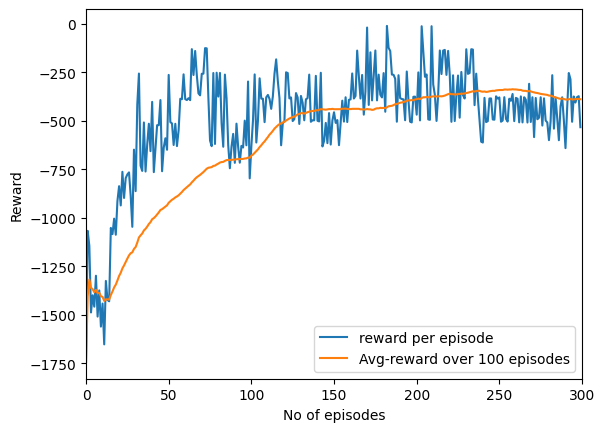

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os

directory_name = os.path.join(os.getcwd(), 'Model/SAC/')

# opening the CSV file
with open(os.path.join(directory_name,'Data_SAC.csv'), mode ='r') as file:
  csvFile = csv.reader(file)
  Pendulum_data = list(csvFile)
  
plt.figure(1)
plt.plot(range(len(Pendulum_data[0])),list(map(float, Pendulum_data[0])),label ='reward per episode')
plt.plot(range(len(Pendulum_data[1])),list(map(float, Pendulum_data[1])),label ='Avg-reward over 100 episodes')
plt.xlabel('No of episodes')
plt.ylabel('Reward')
plt.xlim([0, len(Pendulum_data[1])])
plt.legend()

In [16]:
import numpy as np
import tensorflow as tf
import gymnasium as gym
import os

directory_name = os.path.join(os.getcwd(), 'Model/SAC/')

env = gym.make('Pendulum-v1',render_mode='human') 
state = env.reset()[0]
n_actions = env.action_space.shape[0]
max_action = env.action_space.high[0]
min_action = env.action_space.low[0]

# define ANN topology
actor = ActorNetwork(max_action=max_action, min_action=min_action, n_actions=n_actions, fc1_dims=256, fc2_dims=256) 

actor.build(input_shape=(1,3))

actor.load_weights(os.path.join(directory_name,"actor_network.h5"))

while True:
    action, _ = actor.sample_normal(tf.convert_to_tensor([state], dtype=tf.float32))
    action = action[0]
    state, reward, done, terminated, _ = env.step(action)
    if done or terminated:
        break
env.close()

<font color="red">**Soft Actor-Critic Algorithms and Applications**</font>, **2019**

* Unfortunately, SAC as presented in (Haarnoja et al., 2018c) can suffer from brittleness to the temperature hyperparameter. Unlike in conventional reinforcement learning, where the optimal policy is independent of scaling of the reward function, in maximum entropy reinforcement learning the scaling factor has to be compensated by the choice a of suitable temperature, and a sub-optimal
temperature can drastically degrade performance (Haarnoja et al., 2018c). To resolve this issue, we devise an automatic gradient-based temperature tuning method that adjusts the expected entropy
over the visited states to match a target value. Although this modification is technically simple, we find that in practice it largely eliminates the need for per-task hyperparameter tuning.
* Instead of requiring the user to set the temperature manually, we can automate this process by formulating a different maximum entropy reinforcement learning objective, where the entropy is treated as a constraint. The magnitude of the reward differs not only across tasks, but it also depends on the policy, which improves over time during training. Since the optimal entropy depends on this magnitude, this makes the temperature adjustment particularly difficult: the entropy can vary unpredictably both across tasks and during training as the policy becomes better. Simply forcing the entropy to a fixed value is a poor solution, since the policy should be free to explore more in regions where the optimal action is uncertain, but remain more deterministic in states with a clear distinction between good and bad actions. Instead, we formulate a constrained optimization problem where the average entropy of the policy is constrained, while
the entropy at different states can vary.
* Our aim is to find a stochastic policy with maximal expected return that satisfies a minimum expected entropy constraint. Formally, we want to solve the constrained optimization problem,
* Target entropy for SAC (Automating Entropy Adjustment for Maximum Entropy RL) is $H = -dim|A|$